In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import scipy
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tensorflow import keras, cast
from tensorflow.data import AUTOTUNE
from os import listdir, path , makedirs
from torchvision.datasets import ImageFolder
from tensorflow.keras.optimizers import Adam
# from tensorflow.data import AUTOTUNE as autotune
from tensorflow.keras import Model, backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121, MobileNetV3Large, Xception
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img , ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Input , GlobalAveragePooling2D
from rich.console import Console
from rich.table import Table

# Training parameters
batch_size = 45
img_height = 224
img_width = 224
epochs = 200
epsilon = 0.1

#parent_dir = '/content/drive/My Drive/IndusFruit/parent_dir'
dataset_dir = '/content/drive/My Drive/IndusFruit'
dataset_name='IndusFruit'
base_train_dir = '/content/drive/My Drive/IndusFruit/Train'
base_val_dir = '/content/drive/My Drive/IndusFruit/Validation'
base_test_dir = '/content/drive/My Drive/IndusFruit/Test'

train_dir = '/content/drive/My Drive/IndusFruit/augmented_train'
test_dir = '/content/drive/My Drive/IndusFruit/augmented_test'
val_dir = '/content/drive/My Drive/IndusFruit/augmented_validation'

augmented_dataset_dir = '/content/drive/My Drive/IndusFruit/augmented_dataset'
best_model_path = '/content/drive/My Drive/IndusFruit'
train_adver_dir = '/content/drive/My Drive/IndusFruit/train_adversarial'
val_adver_dir = '/content/drive/My Drive/IndusFruit/val_adversarial'
test_adver_dir = '/content/drive/My Drive/IndusFruit/test_adversarial'
#adversarial_and_normal_dir = '/content/drive/My Drive/IndusFruit/adversarial_and_normal_examples'
os.makedirs(val_adver_dir, exist_ok=True)
os.makedirs(test_adver_dir, exist_ok=True)

os.makedirs(train_adver_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

print(f"Contents of '{base_test_dir}':")
print(os.listdir(base_test_dir))
print(f"Contents of '{base_train_dir}':")
print(os.listdir(base_train_dir))

Contents of '/content/drive/My Drive/IndusFruit/Test':
['banana', 'orange', 'watermelon', 'mango', 'grape', 'strawberry', 'apple']
Contents of '/content/drive/My Drive/IndusFruit/Train':
['strawberry', 'orange', 'watermelon', 'mango', 'apple', 'grape', 'banana']


37


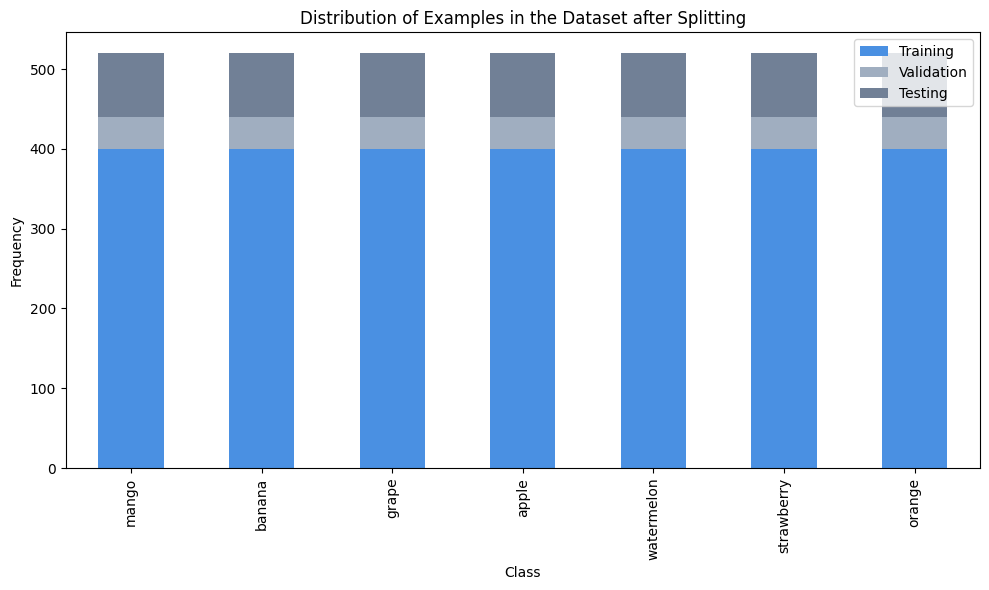

In [ ]:


 # Function to load images and labels
def load_dataset(source_dir):
    images = []
    labels = []

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        if os.path.isdir(class_path):  # Check if it is a directory
            for file_name in os.listdir(class_path):
                img_path = os.path.join(class_path, file_name)
                images.append(img_path)  # Save the file path
                labels.append(class_name)  # Use the class name as the label

    return images, labels

# Load dataset
images, labels = load_dataset(dataset_dir)
print(len(images))
# Define the classes
classes = ['mango', 'banana', 'grape','apple','watermelon' , 'strawberry','orange',]

# Function to count images in each class for each split
def count_images(directory, classes):
    counts = {}
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        if os.path.exists(class_dir):
            counts[cls] = len(os.listdir(class_dir))
        else:
            counts[cls] = 0
            print(f"Warning: Directory for class '{cls}' not found in {directory}")
    return counts

# Get counts for each split
train_counts = count_images(base_train_dir, classes)
validate_counts = count_images(base_val_dir, classes)
test_counts = count_images(base_test_dir, classes)

# Create a DataFrame for easier plotting
data = {
    'Training': train_counts,
    'Validation': validate_counts,
    'Testing': test_counts
}
df = pd.DataFrame(data, index=classes)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a stacked bar plot with lighter professional colors
df.plot(kind='bar', stacked=True, ax=ax, color=['#4a90e2', '#a0aec0', '#718096'])  # Light Blue, Light Gray, Medium Gray

# Labeling
ax.set_ylabel('Frequency')
ax.set_xlabel('Class')
ax.set_title('Distribution of Examples in the Dataset after Splitting')

# Customize legend
ax.legend(title='', labels=['Training', 'Validation', 'Testing'], loc='upper right')

plt.tight_layout()
plt.show()





/content/drive/My Drive/IndusFruit/Train/strawberry
/content/drive/My Drive/IndusFruit/Train/orange
/content/drive/My Drive/IndusFruit/Train/watermelon
/content/drive/My Drive/IndusFruit/Train/mango
/content/drive/My Drive/IndusFruit/Train/apple
/content/drive/My Drive/IndusFruit/Train/grape
/content/drive/My Drive/IndusFruit/Train/banana
/content/drive/My Drive/IndusFruit/Validation/banana
/content/drive/My Drive/IndusFruit/Validation/grape
/content/drive/My Drive/IndusFruit/Validation/mango
/content/drive/My Drive/IndusFruit/Validation/orange
/content/drive/My Drive/IndusFruit/Validation/strawberry
/content/drive/My Drive/IndusFruit/Validation/watermelon
/content/drive/My Drive/IndusFruit/Validation/apple
/content/drive/My Drive/IndusFruit/Test/banana
/content/drive/My Drive/IndusFruit/Test/orange
/content/drive/My Drive/IndusFruit/Test/watermelon
/content/drive/My Drive/IndusFruit/Test/mango
/content/drive/My Drive/IndusFruit/Test/grape
/content/drive/My Drive/IndusFruit/Test/strawb

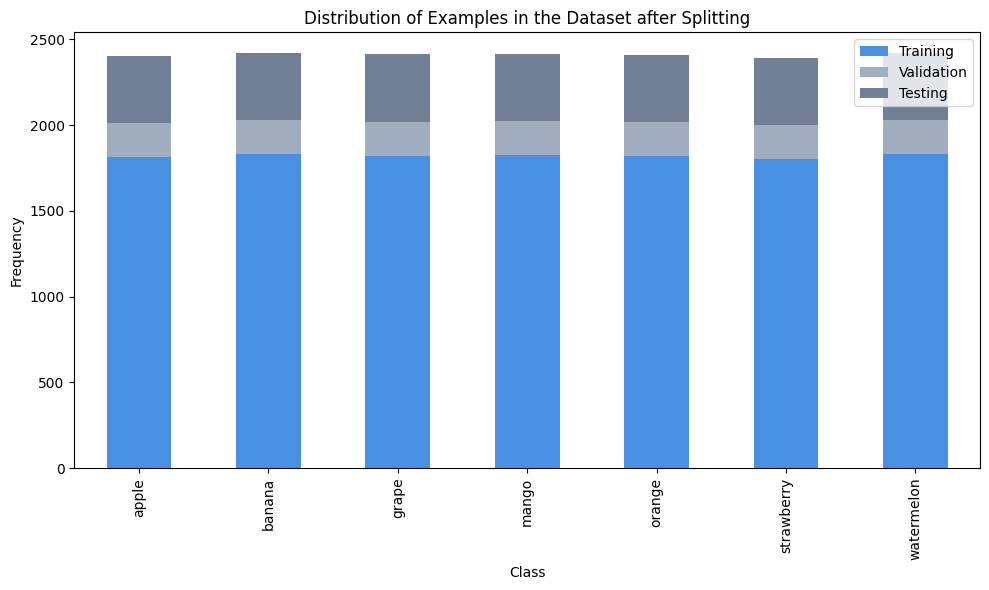

In [ ]:

target_augmentations = 5

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_images_in_dir(input_dir, output_dir, target_augmentations):
    for class_name in os.listdir(input_dir):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        print(class_input_dir)
        if not os.path.isdir(class_input_dir):
            continue

        # Create the class output directory if it doesn't exist
        os.makedirs(class_output_dir, exist_ok=True)

        for img_name in os.listdir(class_input_dir):
            img_path = os.path.join(class_input_dir, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path)
            x = tf.keras.preprocessing.image.img_to_array(img)
            x = x.reshape((1,) + x.shape)  # Reshape to (1, width, height, channels)

            # Generate and save augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_output_dir, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= target_augmentations:
                    break  # Stop after generating the desired number of augmentations
# Apply augmentation to train, validation, and test directories
augment_images_in_dir(base_train_dir, train_dir, target_augmentations)
augment_images_in_dir(base_val_dir, val_dir, target_augmentations)
augment_images_in_dir(base_test_dir, test_dir, target_augmentations)


# Define the classes
classes = ['apple', 'banana', 'grape', 'mango', 'orange','strawberry','watermelon']

# Function to count images in each class for each split
def count_images(directory, classes):
    counts = {}
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        counts[cls] = len(os.listdir(class_dir)) if os.path.exists(class_dir) else 0
    return counts

# Get counts for each split
train_counts = count_images(train_dir, classes)
validate_counts = count_images(val_dir, classes)
test_counts = count_images(test_dir, classes)

# Create a DataFrame for easier plotting
data = {
    'Training': train_counts,
    'Validation': validate_counts,
    'Testing': test_counts
}
df = pd.DataFrame(data, index=classes)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a stacked bar plot with lighter professional colors
df.plot(kind='bar', stacked=True, ax=ax, color=['#4a90e2', '#a0aec0', '#718096'])  # Light Blue, Light Gray, Medium Gray

# Labeling
ax.set_ylabel('Frequency')
ax.set_xlabel('Class')
ax.set_title('Distribution of Examples in the Dataset after Splitting')

# Customize legend
ax.legend(title='', labels=['Training', 'Validation', 'Testing'], loc='upper right')

plt.tight_layout()
plt.show()



In [ ]:
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


In [ ]:
# Data processing
def process(image, label):
    image = tf.image.per_image_standardization(image)  # Normalize pixel values
    return image, label


Found 12747 files belonging to 7 classes.
Found 1385 files belonging to 7 classes.

|------------------------------| Training Xception (Frozen) |--------------------------------|

Epoch 1/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 57s 112ms/step - accuracy: 0.1557 - loss: 12.0240 - precision_3: 0.1557 - recall_3: 0.1425 - val_accuracy: 0.2231 - val_loss: 5.9313 - val_precision_3: 0.2296 - val_recall_3: 0.2014 - learning_rate: 1.0000e-04
Epoch 2/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2396 - loss: 5.0215 - precision_3: 0.2495 - recall_3: 0.2134 - val_accuracy: 0.2505 - val_loss: 4.6277 - val_precision_3: 0.2706 - val_recall_3: 0.2303 - learning_rate: 1.0000e-04
Epoch 3/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2776 - loss: 3.9515 - precision_3: 0.2891 - recall_3: 0.2372 - val_accuracy: 0.2794 - val_loss: 4.0288 - val_precision_3: 0.2944 - val_recall_3: 0.2455 - learning_rate: 1.0000e-04
Epoch 4/30
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3031 - lo

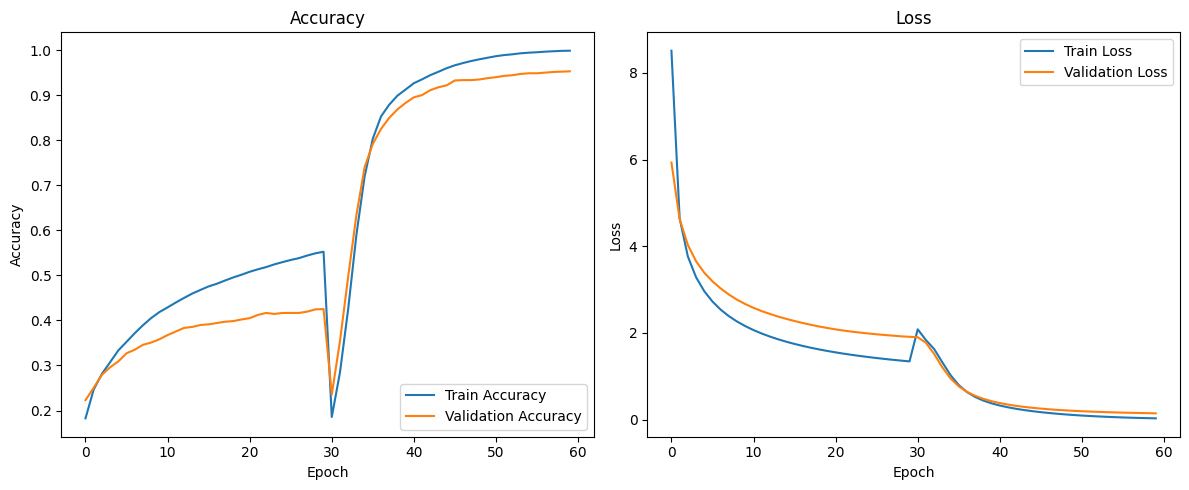

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

img_height, img_width = 224, 224
batch_size = 32
# Learning rates and callbacks
initial_learning_rate = 1e-4
fine_tune_learning_rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
model_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# Check for dataset directories
if not os.path.exists(train_dir):
    raise ValueError(f"Training directory does not exist: {train_dir}")
if not os.path.exists(val_dir):
    raise ValueError(f"Validation directory does not exist: {val_dir}")
# Build Xception model
Xception_base_model = tf.keras.applications.Xception(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
Xception_base_model.trainable = False  # Freeze the base model
# Custom model layers
inputs = Input(shape=(img_height, img_width, 3))
x = Xception_base_model(inputs)
x = GlobalAveragePooling2D()(x)
outputs = Dense(units=7, activation='softmax')(x)
Xception_model = Model(inputs, outputs, name='Xception')
# Compile the model
Xception_model.compile(
    optimizer=Adam(initial_learning_rate),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Prepare the datasets
train_data = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# Train the model
print('\n|------------------------------| Training Xception (Frozen) |--------------------------------|\n')
model_checkpoint_fc = ModelCheckpoint(
    best_model_path + '/normal-xception-' + dataset_name + '-{epoch:02d}-{val_accuracy:.4f}.keras',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy',  # Ensure this monitors validation accuracy
    mode='max')
# Initial training phase
Xception_history = Xception_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    verbose=1,
    callbacks=[model_checkpoint_fc, model_callback, reduce_lr])
# Unfreeze some or all of the layers for fine-tuning
print('\n|------------------------------| Fine-Tuning Xception |--------------------------------|\n')
Xception_base_model.trainable = True  # Unfreeze all layers for fine-tuning
# Re-compile with a lower learning rate for fine-tuning
Xception_model.compile(
    optimizer=Adam(fine_tune_learning_rate),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Fine-tuning phase
Xception_fine_tune_history = Xception_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    verbose=1,
    callbacks=[model_checkpoint_fc, model_callback, reduce_lr])
# Merge history
for key in Xception_fine_tune_history.history.keys():
    if key in Xception_history.history:
        Xception_history.history[key].extend(Xception_fine_tune_history.history[key])
    else:
        Xception_history.history[key] = Xception_fine_tune_history.history[key]

plot_history(Xception_history)



In [ ]:
def generate_adversarial_image(model, image, epsilon):
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)  # Get model predictions
        loss = tf.reduce_mean(prediction)  # Dummy loss using mean prediction
    gradients = tape.gradient(loss, image_tensor)
    signed_gradients = tf.sign(gradients)
    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image.numpy()[0]  # Return the image without batch dimension
def create_adversarial_dataset(model,data_dir, adversarial_dir, epsilon=0.1, limit_ratio=0.5):
    for class_name in listdir(data_dir):
        class_path = path.join(data_dir, class_name)
        adversarial_class_path = path.join(adversarial_dir, class_name)
        # Create directory for adversarial images
        makedirs(adversarial_class_path, exist_ok=True)
        images = listdir(class_path)
        limit_count = int(len(images) * limit_ratio)  # Limit adversarial examples
        for img_name in images:
            img_path = path.join(class_path, img_name)
            img = load_img(img_path, target_size=(224, 224))  # Resize to model input size
            img_array = img_to_array(img) / 255.0  # Normalize the image
            # Generate adversarial image
            adversarial_image = generate_adversarial_image(model, img_array, epsilon)
            # Save the adversarial image if within limit
            # if limit_count > 0:
            save_img(path.join(adversarial_class_path, img_name), adversarial_image)
                # limit_count -= 1


# # Generate adversarial images
best_model_path = '/content/drive/My Drive/IndusFruit/normal-xception-IndusFruit-30-0.9531.keras'
x_ppp = load_model(best_model_path)

create_adversarial_dataset(x_ppp,train_dir, train_adver_dir, epsilon=0.1, limit_ratio=0.5)  # Adjust limit_ratio as needed
create_adversarial_dataset(x_ppp,val_dir, val_adver_dir, epsilon=0.1, limit_ratio=0.5)
create_adversarial_dataset(x_ppp,test_dir, test_adver_dir, epsilon=0.1, limit_ratio=0.5)


Number of classes in training data: 7
Number of classes in validation data: 7
Found 12747 images belonging to 7 classes.
Found 1385 files belonging to 7 classes.

|------------------------------| Fine-Tuning the Loaded Model |--------------------------------|

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 248s 498ms/step - accuracy: 0.8705 - loss: 0.3948 - precision_9: 0.8981 - recall_9: 0.8469 - val_accuracy: 0.9300 - val_loss: 0.2078 - val_precision_9: 0.9473 - val_recall_9: 0.9090 - learning_rate: 1.0000e-05
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 188s 463ms/step - accuracy: 0.9181 - loss: 0.2491 - precision_9: 0.9355 - recall_9: 0.9022 - val_accuracy: 0.9495 - val_loss: 0.1614 - val_precision_9: 0.9599 - val_recall_9: 0.9321 - learning_rate: 1.0000e-05
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 186s 458ms/step - accuracy: 0.9299 - loss: 0.2089 - precision_9: 0.9432 - recall_9: 0.9184 - val_accuracy: 0.9581 - val_loss: 0.1368 - val_precision_9: 0.9683 - val_recall_9: 0.9480 - learning_rate: 

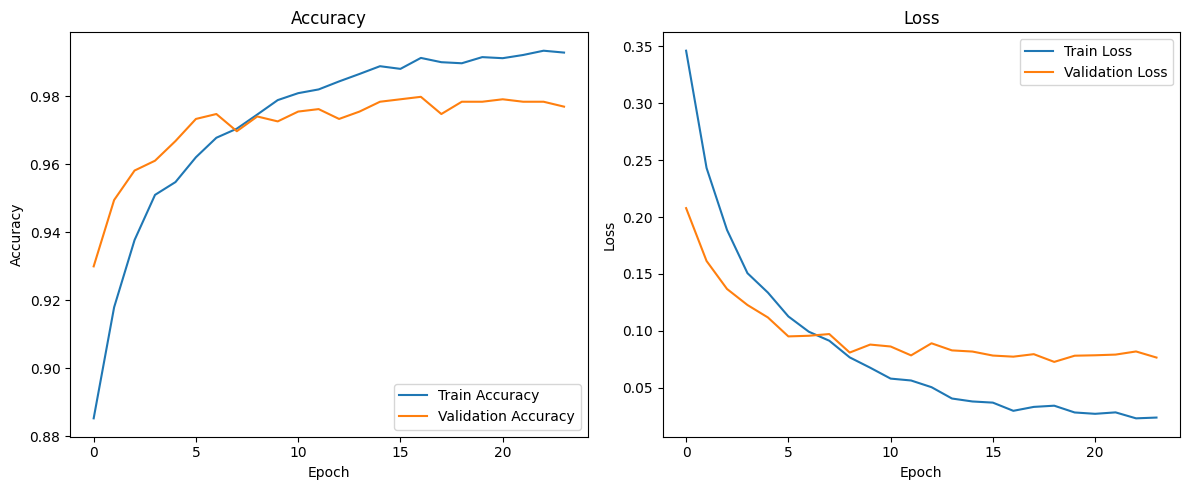

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
# Load the pre-trained xception model
model_path = '/content/drive/My Drive/IndusFruit/normal-xception-IndusFruit-30-0.9531.keras'
xception_loaded_model = load_model(model_path)
train_classes = len(adversarial_train_data.class_indices)
val_classes = len(os.listdir(val_adver_dir))  # Assuming one folder per class

print(f"Number of classes in training data: {train_classes}")
print(f"Number of classes in validation data: {val_classes}")
# Add Dropout Layer
x = xception_loaded_model.layers[-2].output  # Output from GlobalAveragePooling2D
x = Dropout(0.6)(x)  # Dropout with 60% rate
output = xception_loaded_model.layers[-1](x)  # Pass through the original Dense layer
xception_loaded_model = Model(inputs=xception_loaded_model.input, outputs=output)
# Apply L2 Regularization
for layer in xception_loaded_model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(0.01)
# Unfreeze Layers for Fine-Tuning
for layer in xception_loaded_model.layers:
    layer.trainable = True
# Recompile the Model
fine_tune_learning_rate = 1e-5
xception_loaded_model.compile(
    optimizer=Adam(learning_rate=fine_tune_learning_rate),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Data Augmentation for Adversarial Training
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,  # Added zoom augmentation
    brightness_range=[0.8, 1.2]  # Adjust brightness
    )
adversarial_train_data = train_data_gen.flow_from_directory(
    train_adver_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
adversarial_val_data = image_dataset_from_directory(
    val_adver_dir,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# Callbacks for Fine-Tuning
fine_tune_callbacks = [
    ModelCheckpoint(
        filepath=best_model_path + f'/fine_tuned_adv_xception-{dataset_name}-{{epoch:02d}}-{{val_accuracy:.4f}}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)]
# Fine-Tune the Model
print('\n|------------------------------| Fine-Tuning the Loaded Model |--------------------------------|\n')
fine_tuning_xception_adv_history = xception_loaded_model.fit(
    adversarial_train_data,
    validation_data=adversarial_val_data,
    epochs=50,
    verbose=1,
    callbacks=fine_tune_callbacks)

plot_history(fine_tuning_xception_adv_history)


In [4]:

normal_data = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=32
)
# normal_data = normal_data.map(process)
normal_data = normal_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Create validation dataset
adversarial_data = image_dataset_from_directory(
    test_adver_dir,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=32
)

# adversarial_data = adversarial_data.map(process)
adversarial_data = adversarial_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


normal_model = load_model('/content/drive/My Drive/IndusFruit/normal-xception-IndusFruit-30-0.9531.keras')
adversarial_model_1 = load_model('/content/drive/My Drive/IndusFruit/fine_tuned_adv_xception-IndusFruit-17-0.9798.keras')



print("xception Model Results:")



print("Normal Model Results:")
normal_model_on_normal_data = normal_model.evaluate(normal_data)
print("Results with normal data", normal_model_on_normal_data)
normal_model_on_adversarial_data = normal_model.evaluate(adversarial_data)
print("Results with Adversarial Data:", normal_model_on_adversarial_data)

print("adversarial Model 1 Results:")
adversarial_1_model_on_normal_data = adversarial_model_1.evaluate(normal_data)
print("Results with normal data", adversarial_1_model_on_normal_data)
normal_model_on_adversarial_data = adversarial_model_1.evaluate(adversarial_data)
print("Results with Adversarial Data:", normal_model_on_adversarial_data)

# Evaluate the model and print all metrics
evaluation_results = normal_model.evaluate(val_data, verbose=1)

# Retrieve metric names and their values
metric_names = normal_model.metrics_names
evaluation_summary = dict(zip(metric_names, evaluation_results))





Found 2742 files belonging to 7 classes.
Found 2742 files belonging to 7 classes.
xception Model Results:
Normal Model Results:
86/86 ━━━━━━━━━━━━━━━━━━━━ 67s 664ms/step - accuracy: 0.9479 - loss: 0.1740 - precision_4: 0.9515 - recall_4: 0.9420
Results with normal data [0.19466517865657806, 0.9401896595954895, 0.9456160068511963, 0.9321662783622742]
86/86 ━━━━━━━━━━━━━━━━━━━━ 68s 789ms/step - accuracy: 0.6064 - loss: 1.1362 - precision_4: 0.8041 - recall_4: 0.5484
Results with Adversarial Data: [1.1511529684066772, 0.6002917289733887, 0.7960172295570374, 0.5393872857093811]
adversarial Model 1 Results:
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9654 - loss: 0.5112 - precision_9: 0.9677 - recall_9: 0.9636
Results with normal data [0.5246363878250122, 0.9624361991882324, 0.96518874168396, 0.9606127142906189]
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9578 - loss: 0.5327 - precision_9: 0.9598 - recall_9: 0.9556
Results with Adversarial Data: [0.549590528011322, 0.954

NameError: name 'val_data' is not defined